In [1]:
"""Supervised data compression via linear
discriminant analysis"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Manually Principal Component Analysis

In [2]:
# Reading wine data
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                       header=None)
# in the data first column is class label and rest
# 13 columns are different features
X,y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [3]:
# Splitting Data into training set and test set
# using scikit-learn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=0.3,
                                stratify=y, random_state=0)
# #Standardarising all the columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std  = sc.transform(X_test)
np.unique(y)

array([1, 2, 3], dtype=int64)

In [4]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],
                             axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [6]:
# we need to standarise the 
# individual scatter matrix 
d = 13 #number of features
S_W = np.zeros((d,d)) #returns array filled with zeors of given shape
for label, mv, in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' %(
      S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [7]:
#between the class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1) 
    mean_overall = mean_overall.reshape(d,1)
    S_B += n*(mean_vec - mean_overall).dot((mean_vec-mean_overall).T)
print('Between-class scatter matrix: %sx%s' %(
       S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [11]:
# eigen pairs
eigen_vals, eigen_vecs = \
    np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
                for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, 
                    key= lambda k: k[0], reverse = True)
print(('Eigenvalues in descending order:\n'))
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


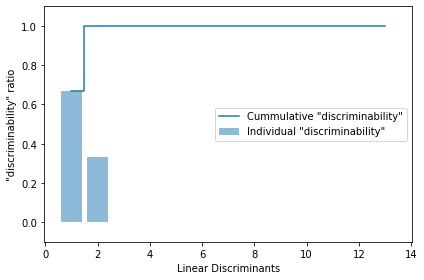

In [12]:
tot = eigen_vals.sum()
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1,14), discr, alpha=0.5, align='center',
       label='Individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid',
         label='Cummulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [13]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
                eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


In [15]:
# converting 13 feature data to 2 feature data
X_train_lda = X_train_std.dot(w)

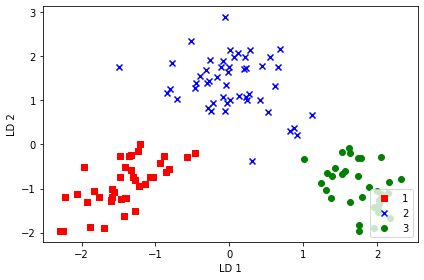

In [16]:
# Plotting the features on
colors  = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l,c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1],
                c = c, label=l, marker = m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

LDA via scikit-learn

In [21]:
# Class to plot  decision region
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap    = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min()-1, X[:, 0].max()+1
    x2_min, x2_max = X[:, 1].min()-1, X[:, 1].max()+1
    
    xx1,xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y==cl, 0], 
                    y = X[y==cl, 1],
                    alpha = 0.6,
                    color = cmap(idx),
                   edgecolor='black',
                   marker=markers[idx],
                   label=cl)

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

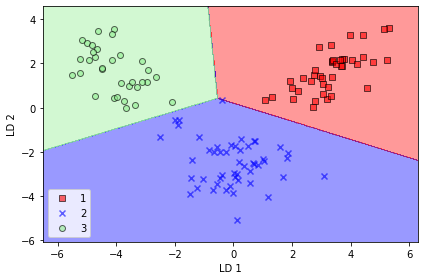

In [23]:
# Plotting decision region of training set after applying PCA
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='ovr', random_state=1,
                        solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

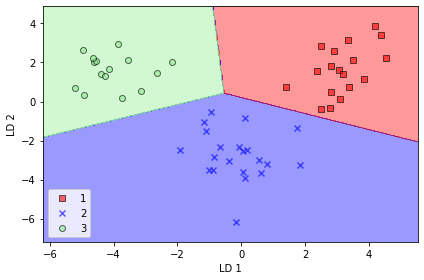

In [25]:
# plotting decision region on test data set
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()